<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/01_query_engine_subquestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SubQuestionQueryEngine

`SubQuestionQueryEngine` was mainly designed to tackle complex queries, in which case more than one data source was provided, and often times queries to compare and contrast certain categories are triggered.

`SubQuestionQueryEngine` generates sub-questions given descriptions of data sources. It then executes sub-questions on the selected data source, gathers sub-responses, and synthesizes a final answer.

We will download the executive summaries of the U.S. government’s financial reports for fiscal years 2021 and 2022. We will use these two summary reports as our data sources and ask questions about the content of these two reports.

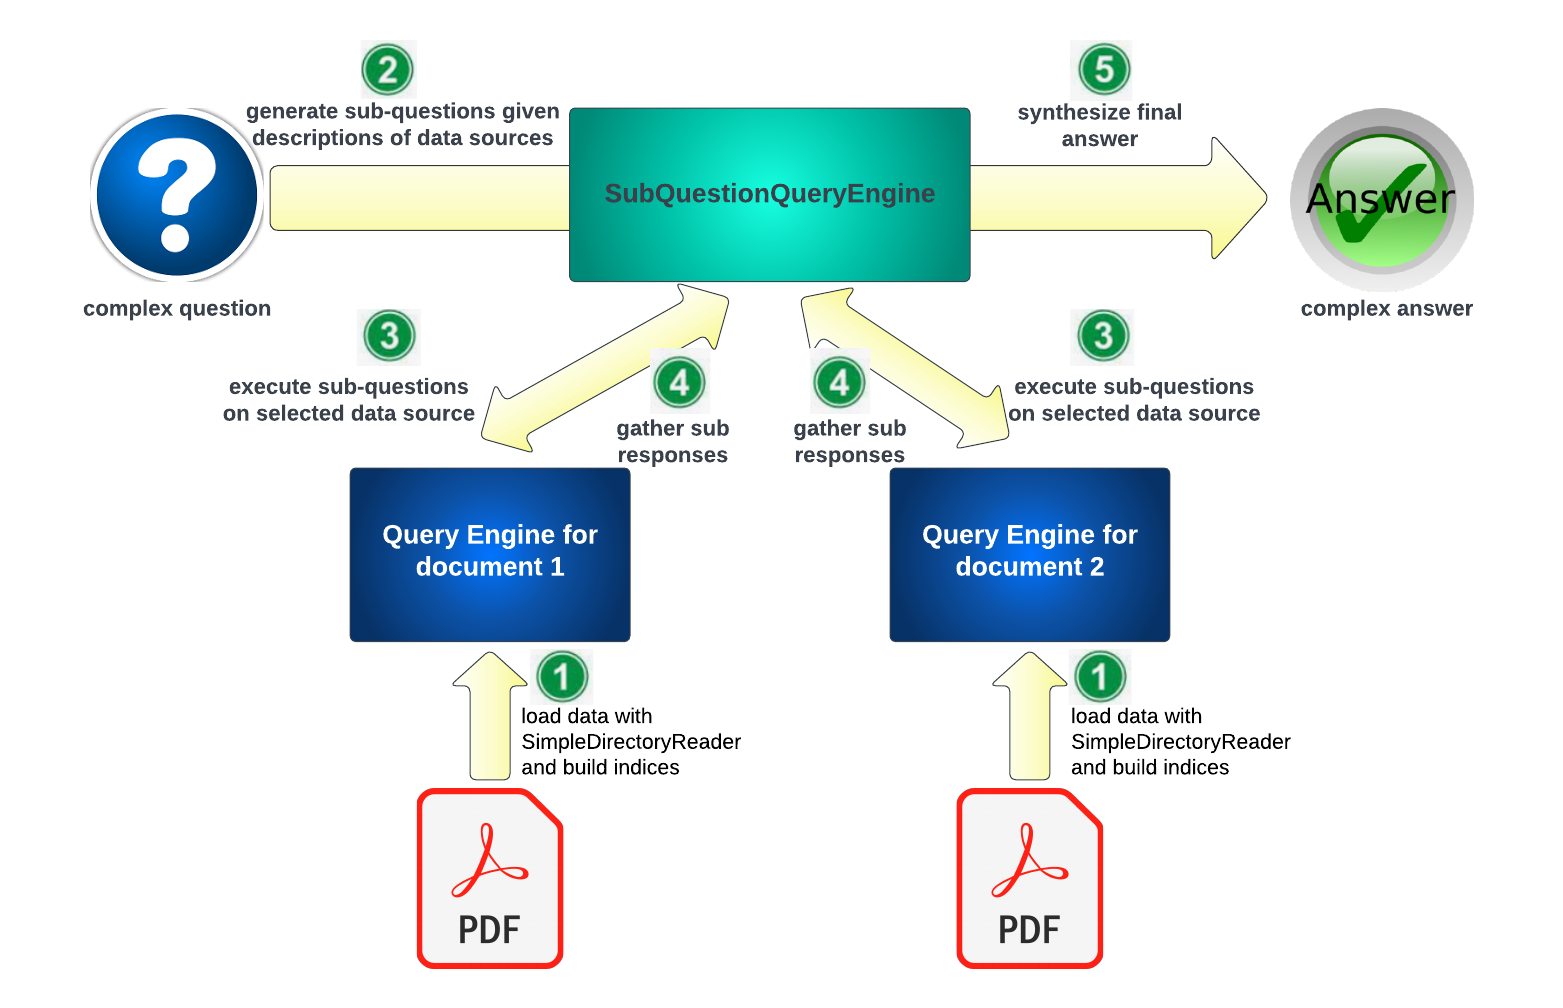

## Step 1: Install and Setup

In [ ]:
!pip install -q llama_index pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.0/631.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [ ]:
import logging, sys, os
import nest_asyncio
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# serves to enable nested asynchronous event loops, recommended for colab notebook
nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Step 2: Download Data

Download financial report executive summaries for 2021 and 2022 from fiscal.treasury.gov website, save the reports to "reports" directory.

In [ ]:
!mkdir reports
!wget https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2021/executive-summary-2021.pdf -O ./reports/executive-summary-2021.pdf
!wget https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2022/executive-summary-2022.pdf -O ./reports/executive-summary-2022.pdf

--2024-02-16 16:54:13--  https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2021/executive-summary-2021.pdf
Resolving www.fiscal.treasury.gov (www.fiscal.treasury.gov)... 166.123.218.167, 2610:108:4100:100c::8:118
Connecting to www.fiscal.treasury.gov (www.fiscal.treasury.gov)|166.123.218.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1001902 (978K) [application/pdf]
Saving to: ‘./reports/executive-summary-2021.pdf’

./reports/executive 100%[===================>] 978.42K   662KB/s    in 1.5s    

2024-02-16 16:54:15 (662 KB/s) - ‘./reports/executive-summary-2021.pdf’ saved [1001902/1001902]

--2024-02-16 16:54:15--  https://www.fiscal.treasury.gov/files/reports-statements/financial-report/2022/executive-summary-2022.pdf
Resolving www.fiscal.treasury.gov (www.fiscal.treasury.gov)... 166.123.218.167, 2610:108:4100:100c::8:118
Connecting to www.fiscal.treasury.gov (www.fiscal.treasury.gov)|166.123.218.167|:443... connected.
HTTP reques

## Step 3: Load data, build indices, define SubQuestionQueryEngine

In [ ]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

#load data
report_2021_docs = SimpleDirectoryReader(input_files=["reports/executive-summary-2021.pdf"]).load_data()
print(f"loaded executive summary 2021 with {len(report_2021_docs)} pages")

report_2022_docs = SimpleDirectoryReader(input_files=["reports/executive-summary-2022.pdf"]).load_data()
print(f"loaded executive summary 2022 with {len(report_2022_docs)} pages")

#build indices
report_2021_index = VectorStoreIndex.from_documents(report_2021_docs)
print(f"built index for executive summary 2021 with {len(report_2021_index.docstore.docs)} nodes")

report_2022_index = VectorStoreIndex.from_documents(report_2022_docs)
print(f"built index for executive summary 2022 with {len(report_2022_index.docstore.docs)} nodes")

#build query engines
report_2021_engine = report_2021_index.as_query_engine(similarity_top_k=3)
report_2022_engine = report_2022_index.as_query_engine(similarity_top_k=3)

#build query engine tools
query_engine_tools = [
    QueryEngineTool(
        query_engine = report_2021_engine,
        metadata = ToolMetadata(name='executive_summary_2021', description='Provides information on US government financial report executive summary 2021')
    ),
    QueryEngineTool(
        query_engine = report_2022_engine,
        metadata = ToolMetadata(name='executive_summary_2022', description='Provides information on US government financial report executive summary 2022')
    )
]

#define SubQuestionQueryEngine
sub_question_engine = SubQuestionQueryEngine.from_defaults(query_engine_tools=query_engine_tools)

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loaded executive summary 2021 with 11 pages
loaded executive summary 2022 with 10 pages
built index for executive summary 2021 with 16 nodes
built index for executive summary 2022 with 11 nodes


## Step 4: Execute Queries

In [ ]:
from IPython.display import Markdown

response = sub_question_engine.query("Compare and contrast the DoD costs between 2021 and 2022")
display(Markdown(f"<b>{response}</b>"))

Generated 2 sub questions.
[executive_summary_2021] Q: What are the DoD costs in 2021?
[executive_summary_2022] Q: What are the DoD costs in 2022?
[executive_summary_2022] A: The DoD costs in 2022 increased by $568.4 billion.
[executive_summary_2021] A: The DoD costs in 2021 increased by $144.8 billion. This increase was primarily due to a $100.2 billion loss increase from changes in assumptions, as well as slight increases in net costs across DOD’s major programs, including military operations, readiness, support, procurement, personnel, and R&D.


<b>The DoD costs increased significantly between 2021 and 2022. In 2021, the DoD costs increased by $144.8 billion, primarily due to changes in assumptions and slight increases in net costs across various programs. However, in 2022, the DoD costs increased even more, by $568.4 billion. This indicates a substantial increase in expenses for the Department of Defense from one year to the next.</b>

In [ ]:
response = sub_question_engine.query("Compare and contrast the total liabilities between 2021 and 2022")
display(Markdown(f"<b>{response}</b>"))

Generated 2 sub questions.
[executive_summary_2021] Q: What is the total liabilities in 2021?
[executive_summary_2022] Q: What is the total liabilities in 2022?
[executive_summary_2022] A: The total liabilities in 2022 were $39.0 trillion.
[executive_summary_2021] A: The total liabilities in 2021 amount to $34.8 trillion.


<b>The total liabilities increased from $34.8 trillion in 2021 to $39.0 trillion in 2022.</b>

In [ ]:
response = sub_question_engine.query("Compare government tax and other revenues for 2021 and 2022")
display(Markdown(f"<b>{response}</b>"))

Generated 2 sub questions.
[executive_summary_2021] Q: What were the government tax revenues in 2021?
[executive_summary_2022] Q: What were the government tax revenues in 2022?
[executive_summary_2021] A: The government tax revenues in 2021 were $4.3 trillion.
[executive_summary_2022] A: The government tax revenues in 2022 were approximately $4.9 trillion.


<b>Government tax revenues increased from $4.3 trillion in 2021 to approximately $4.9 trillion in 2022.</b>

In [ ]:
response = sub_question_engine.query("Compare the individual income tax and tax withholdings, corporate income taxes, and other revenue in detailed dollar amount between 2021 and 2022")
display(Markdown(f"<b>{response}</b>"))

Generated 8 sub questions.
[executive_summary_2021] Q: What is the individual income tax revenue in 2021?
[executive_summary_2022] Q: What is the individual income tax revenue in 2022?
[executive_summary_2021] Q: What are the tax withholdings in 2021?
[executive_summary_2022] Q: What are the tax withholdings in 2022?
[executive_summary_2021] Q: What is the corporate income tax revenue in 2021?
[executive_summary_2022] Q: What is the corporate income tax revenue in 2022?
[executive_summary_2021] Q: What is the other revenue in 2021?
[executive_summary_2022] Q: What is the other revenue in 2022?
[executive_summary_2022] A: The individual income tax revenue in 2022 is approximately $4.9 trillion.
[executive_summary_2022] A: In FY 2022, tax withholdings accounted for a significant portion of the total tax and other revenues of the U.S. government.
[executive_summary_2022] A: The other revenue in 2022 was not explicitly mentioned in the given context information.
[executive_summary_2021] A:

<b>The context information does not provide detailed dollar amounts for the individual income tax, tax withholdings, corporate income taxes, and other revenue in 2021 and 2022. Therefore, it is not possible to compare these revenue sources in terms of specific dollar amounts based on the given context.</b>